# Search Query Classification with Topic Modeling: Latent Dirichlet Allocation (LDA)

テキストデータなどの非構造データをモデリングするにあたり、様々な手法がこれまでに研究されてきましたが、今回は潜在的ディリクレ配分法(LDA)を使ってWEBサービスの検索キーワードを分類することを考えてみたいと思います。

## Contents
- イントロダクション
- 学習アルゴリズム
- LDAを支える数学的背景
- 前処理(Bag of Wordsの作成)
- 変分パラメータの初期化
- 変分推論の反復
    - $\phi$の更新(Eステップ)
    - $\gamma$の更新(Eステップ)
    - $\beta$の更新(Mステップ)
    - ELBO(変分下限)の計算
- 学習済みモデルの利用

## イントロダクション

LDAは、pLSIというモデルの弱点を克服する文脈で紹介されていました。
pLSIには、以下のような難点がありました。
- 入力として与えるテキストデータの分量が増えるほどパラメータ数が線形的に増えてしまう
- 訓練データに存在しない文書に対してどのようにトピックの確率を割り当てるかが不明瞭

LDAは生成確率モデルであり、これらの点にアプローチできるといいます。
基本的なコンセプトは、文書中の各単語は潜在的なトピックの分布により生成されているというものです。

In [ ]:
from IPython.display import Image

# 学習アルゴリズム

論文では、LDAの学習アルゴリズムとして変分推論が提案されています。

真の分布が不明な状況下で精度のよい確率モデルを組むためには、観測値$x$が従う未知の真の分布$p^*(x)$をどのように推測するかが重要になるのですが、真の分布は直接わからないため、真の分布を近似した$x\sim p_\theta(x)$を仮定してこのあとのタスクを解いていきます。そのためここでいう"学習"とは$p_\theta(x)\approx p^*(x)$となるようなパラメータ$\theta$を探索することに相当します。学習手順としてはEMアルゴリズムが有名ですが、LDAの事後分布$p(\theta, z|w)$は解析的に計算することができないため、EMアルゴリズムにおけるEステップを近似的に行うために変分推論を使います。

具体的な手順は以下の通りです。
- 変分パラメータの初期化
- 変分推論の反復
    - $\phi$の更新(Eステップ)
    - $\gamma$の更新(Eステップ)
    - $\beta$の更新(Mステップ)
    - ELBO(変分下限)の計算
- 学習済みモデルの利用

# LDAを支える数学的背景

## ガンマ関数

$$
\Gamma(z) = \int_0^\infty t^{z-1}e^{-t}dt
$$

## ディガンマ関数(プサイ関数):ガンマ関数の対数微分(1階微分)

$$
\Psi(x) = \frac{d}{dx}log\Gamma(x) = \frac{1}{\Gamma(x)}\frac{d\Gamma(x)}{dx}
$$

## A1.期待値の演算

$$
p(\theta|\alpha) = \exp\left(\sum_{i=1}^k(\alpha_i-1)\log{\theta_i} + \log\gamma\left(\sum_{i=1}^k \alpha_i\right) - \sum_{i=1}^k \log \gamma (\alpha_i)\right)
$$

$$
E[\log\theta_i | \alpha] = \Psi(\alpha_i) - \Psi\left( \sum_{j=1}^k \alpha_j \right)
$$

$$
\frac{\partial}{\partial \alpha_i}\left( \sum_{i=1}^k \log \Gamma (\alpha_i) \right) = \Psi(\alpha_i)
$$

## A2.ニュートンラフソン法

## A3.変分推論

$$
q\left( \theta, z|\gamma, \phi \right) = q(\theta|\gamma) \prod_{n=1}^N q\left(z_n|\phi_n\right)
$$

## A3.1.$\phi_{ni}$について変分下限を最大化するよう最適化

$$
L_{[\phi_{ni}]} = \phi_{ni} \left(\Psi(\gamma_i)-\Psi\left( \sum_{j=1}^k\gamma_j \right) + \phi_{ni} \log\beta_{i\nu}-\phi_{ni}\log\phi_{ni}+\lambda_n\left(\sum_{j=1}^k\phi_{ni}-1\right)\right)
$$

両辺を$\phi_{ni}$で偏微分して

$$
\frac{\partial L}{\partial\phi_{ni}} = \Psi\left(\gamma_i\right)-\Psi\left(\sum_{j=1}^k\gamma_j\right)+\log \beta_{i\nu}-\log \phi_{ni}-1+\lambda_n
$$

これを0とおくことで、最大値を与える$\phi_{ni}$の値が得られる

$$
\phi_{ni} \propto \beta_{i\nu}\exp\left(\Psi\left(\gamma_i\right)-\Psi\left(\sum_{j=1}^k\gamma_j\right)\right)
$$

## A3.2.$\gamma_i$について変分下限を最大化するよう最適化

ELBOの式全体の中から、$\gamma_i$に関する項のみ抜き出すと

$$
L_{[\gamma]} = \sum_{i=1}^k\left(\Psi\left(\gamma_i\right)-\Psi\left(\sum_{j=1}^k\gamma_j\right)\right)\left(\alpha_i+\sum_{n=1}^N\phi_{ni}-\gamma_i\right)-\log\Gamma\left(\sum_{j=1}^k\gamma_j\right)+\log\Gamma\left(\gamma_i\right)
$$

両辺を$\gamma_i$で偏微分して

$$
\frac{\partial L}{\partial\gamma_i} = \Psi'\left(\gamma_i\right)\left(\alpha_i+\sum_{n=1}^N\phi_{ni}-\gamma_i\right)-\Psi'\left(\sum_{j=1}^k\gamma_j\right)\sum_{j=1}^k\left(\alpha_j+\sum_{n=1}^N\phi_{ni}-\gamma_j\right)
$$

## A4.パラメータ予測

### A4.1条件つき多項分布

目的：モデルパラメータ$\beta$について変分下限を最大化するため、$\beta$の更新式を導出

$$
L_{[\beta]} = \sum_{d=1}^M\sum_{n=1}^{N_d}\sum_{i=1}^k\sum_{j=1}^V\phi_{dni}w_{dn}^j\log\beta_{ij}+\sum_{i=1}^k\lambda_i\left(\sum_{j=1}^V\beta_{ij}-1\right)
$$

$$
\beta_{ij}\propto\sum_{d=1}^M\sum_{n=1}^{N_d}\phi_{dni}w_{dn}^j
$$

$\beta+{ij}$で偏微分して、変分下限を0とおくと
$$\sum_{d=1}^M\sum_{n=1}^{N_d}\phi_{dni}w_{dn}^j\frac{1}{\beta_{ij}}+\lambda_i=0$$
$$\Leftrightarrow\beta_{ij} = -\frac{1}{\lambda_i}\sum_{d=1}^M\sum_{n=1}^{N_d}\phi_{dni}w_{dn}^j$$
ここで、制約条件
$$\sum_{j=1}^V\beta_{ij}=1$$
により、常識をすべての$j$について足し合わせると
$$\sum_{j=1}^V\beta_{ij} = \sum_{j=1}^V\left( -\frac{1}{\lambda_i}\sum_{d=1}^M\sum_{n=1}^{N_d}\phi_{dni}w_{dn}^j \right)=1$$

$$\Leftrightarrow-\frac{1}{\lambda_i}\sum_{j=1}^V\sum_{d=1}^M\sum_{n=1}^{N_d}\phi_{dni}w_{dn}^j=1$$

$$\beta_{ij} = \frac{\sum_{d=1}^M\sum_{n=1}^{N_d}\phi_{dni}w_{dn}^j}{\sum_{j=1}^V\sum_{d=1}^M\sum_{n=1}^{N_d}\phi_{dni}w_{dn}^j}$$

ここで、分母は$i$番目のトピックに関するすべての単語の確率の和に等しいため、定数とみなせる。

$$\therefore\beta_{ij}\propto\sum_{d=1}^M\sum_{n=1}^{N_d}\phi_{dni}w_{dn}^j$$

### A.4.2 ディリクレ分布

Appendix A.4.2では、モデルパラメータ$\alpha$の更新式を導出するために、$\alpha$を含む変分下限(ELBO)の項を抽出し、$\alpha$に関する偏微分を計算している。しかし、$\alpha$に関する偏微分は、他の$\alpha_j(j\ne i)$にも依存するため、解析的に解くことができない。そこでニュートンラフソン法などの反復法を用いて$\alpha$を最適化する。特にヘッセ行列が特定の構造を持つため、Appendix A.2で説明されている線形時間のニュートンラフソン法を適用できることが示されている。

$\alpha$を含む項は

$$
L_{[\alpha]} = \sum_{d=1}^M\left(\log\Gamma\left(\sum_{j=1}^k\alpha_j\right)-\sum_{i=1}^k\log\Gamma\left(\alpha_j\right)+\sum_{i=1}^k\left(\left(\alpha_j-1\right)\left(\Psi\left(\gamma_{di}\right)-\Psi\left(\sum_{j=1}^k\gamma_{dj}\right)\right)\right)\right)
$$

$\alpha_i$に関して微分すると

$$
\frac{\partial L}{\partial \alpha_i} = M\left(\Psi\left(\sum_{j=1}^k\alpha_j\right)-\Psi\left(\alpha_i\right)\right)+\sum_{d=1}^M\left(\Psi\left(\gamma_{di}\right)-\Psi\left(\sum_{j=1}^k\gamma_{dj}\right)\right)
$$

しかし、$\alpha$に関する偏微分は、他の$\alpha_j(j\ne i)$にも依存しており解析的に解くことができないため、最大値を与える$\alpha$を求めるためには反復法を使用する必要がある。

特にヘッセ行列は、式(10)

$$
H = diag(h)+\bf{1} z \bf{1}^T\bf
$$

に見られる形であり

$$
\frac{\partial L}{\partial \alpha_i\alpha_j} = \delta(i,j)M\Psi'\left(\alpha_i\right)-\Psi'\left(\sum_{j=1}^k\alpha_j\right)
$$

となる。この構造ゆえ、Appendix A.2 に書かれた線形時間のニュートンラフソン法のアルゴリズムを呼び出すことができる。

最後に、5.4節に記された平滑LDAモデルにおける交換可能なディリクレ分布のスカラーパラメータである$\eta$を求めるための経験ベイズ点推定には、$\alpha$の推定と同様にニュートンラフソン法を用いることができる。

# 前処理(Bag of Wordsの作成)

# 変分パラメータの初期化

ここでは変分推論の最初のステップとして、変分パラメータの初期化を行います。変分パラメータは下記の2種類があります。
- $\gamma$: 各文書の$d$のトピック分布$\theta_d$を近似するディリクレ分布のパラメータ。各文書$d$に対して$k$個の値を持つベクトル($\gamma_d\in\mathbb{R}^k)$
- $\phi$: 各文書$d$の各単語$n$のトピック割り当て$z_{dn}$を近似する多項分布のパラメータ。各文書$d$の各単語$n$に対して$k$個の値を持つベクトル$(\phi_{dn}\in\mathbb{R}^k)$

ここでは簡単のため、$\gamma$と$\phi$をランダム

# LDAモデルの定義

In [5]:
import numpy as np
num_topics = 10
num_words = 1_000
alpha = np.full(num_topics, 0.5)
beta = np.full(num_words, 0.5)

# ノート

$$
\phi^* = \arg\max_{\phi}\mathbf{E}_{p^*\left(x\right)}\left[\log p\left(x|\phi\right)\right]\\
\mathbf{E}_{p^*\left(x\right)}: 確率分布 p^*\left(x\right)による期待値
$$

この最適化問題は未知の確率分布
$$
p^*\left(x\right)
$$

を含んでいるため、このままでは解析不可能。
そこで、データを真の分布からのサンプルとして、つまり

$$
x_i \approx p^*\left(x\right)
$$
として期待値計算を近似する。
$$
\mathbf{E}_{p^*\left(x\right)}\left[\log{p\left(x|\phi\right)}\right] \approx \frac{1}{n}\sum^{n}_{i=1}\log p\left(x|\phi\right)
$$
すなわち
$$
\phi^* = \arg\max_\phi\frac{1}{n}\sum_{i=1}^{n}\log p\left(x_i|\phi\right)
$$
これは$$\textbf{最尤推定(maximum likelihood estimation)}$$と呼ばれる。

ここで過学習を防ぎ汎化性能をもたせるため、φに関する生成過程も考慮すると、
$$
\phi^* = \arg\max_\phi \left( \log p\left( \phi | \eta \right) + \sum_{i=1}^n \log p \left( x_i|\phi \right)\right)
$$
これは$$\textbf{事後確率最大推定(maximum a posteriori)}$$と呼ばれる。

つぎに潜在変数を扱うため、ギブスサンプリングにより近似的に事後確率最大推定を行う。

# Dirichlet 分布のパラメータ推定

$\alpha$: 文書ごとのトピック分布\\
$\beta$: トピックごとの単語分布\\
$\alpha$と$\beta$の対称/非対称により、LDAの性質を大きく左右するが、ここではストップワードをまとめて抽出できる傾向にあると紹介されている$\alpha$-非対称/$\beta$-対称を用いることとする。

# 固定点反復法

In [4]:
import numpy as np
from scipy.special import psi  # psi = digamma 関数

式3.191：$\alpha$の更新式
$$
\alpha_k = \frac{ \sum_{d=1}^{M}a_{d,k}} {\sum_{d=1}^{M}b_d} = \frac{
    \sum_{d=1}^{M} \left[ 
                        \Psi\left(
                                    \bf{E} \left[ n_{d,k} \right]
                                    + \hat{\alpha}_k 
                                    - \Psi \left( \hat{\alpha}_k \right)
                        \right)
    \right]
    \hat{\alpha}_k
    }{
    \sum_{d=1}^{M} \left[ 
                        \Psi\left(
                                    n_d + \sum^K_{k=1} \hat{\alpha}_k \right)
                                    - \Psi \left( \sum^K_{k=1} \hat{\alpha}_k \right)
    \right]
    }
$$

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import psi
def alpha_update(alpha_hat, n_dk, n_d, max_iter = 100, tolerance = 1e-6):
    M = len(n_d) # 文書数
    K = len(alpha_hat) # トピック数
    alpha_new = np.zeros(K)
    sum_alpha_hat = np.sum(alpha_hat)
    denominator = 0 # 文書ごとに一定なので、ループの外で先に計算
    for d in range(M):
        denominator += psi(n_d[d] + sum_alpha_hat) - psi(sum_alpha_hat)
    for k in range(K): # 各トピックkごとの分子および alpha_k の更新
        numerator = 0 # 分子
        for d in range(M): 
            numerator += ( psi(n_dk[d,k]) + alpha_hat[k] - psi(alpha_hat[k]) ) * alpha_hat[k]
        alpha_new[k] = numerator / denominator
    return alpha_new

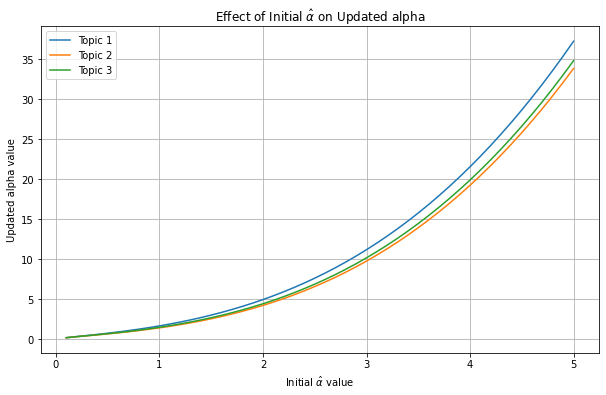

In [20]:
# 仮の観測データ
M = 10  # 文書数
K = 3   # トピック数

# 文書ごとのトピック割り当てカウント
np.random.seed(42)
n_dk = np.random.poisson(5, size=(M, K))
n_d = np.sum(n_dk, axis=1)

# 初期 alpha_hat を変化させて出力 alpha を観察
alphas = []
alpha_hat_values = np.linspace(0.1, 5.0, 50)
for a in alpha_hat_values:
    alpha_hat = np.full(K, a)
    alpha = alpha_update(alpha_hat, n_dk, n_d)
    alphas.append(alpha)

alphas = np.array(alphas)

# 可視化
plt.figure(figsize=(10, 6))
for k in range(K):
    plt.plot(alpha_hat_values, alphas[:, k], label=f'Topic {k+1}')
plt.xlabel(r'Initial $\hat{\alpha}$ value')
plt.ylabel('Updated alpha value')
plt.title(r'Effect of Initial $\hat{\alpha}$ on Updated alpha')
plt.legend()
plt.grid(True)
plt.show()

ここで、$\bf\beta$に関しては低頻度の単語などが含まれることより、データ量の観点から単語ごとに$\beta_v$を推定することは必ずしもよいとは限らない。

したがって、ここではすべての単語に対して同じ値$\beta$を用いることとする。

式3.194
$$
\beta = \frac{1}{V} \frac{
\sum_{k=1}^K \sum_{v=1}^V \left[ \Psi \left(
                    \bf{E} \left[ n_{k,v} \right] + \hat{\beta}
                                      \right) - \Psi\left( \hat{\beta} \right) \right] \hat{\beta}
}{
\sum_{k=1}^K \left[ \Psi \left(
                    \sum_{v=1}^V
                    \bf{E} \left[ n_{k,v} \right] + \hat{\beta}
                                      \right) - \Psi\left( V\hat{\beta} \right) \right]
}
$$

In [11]:
def beta_update(beta_hat, n_kv):
    # 分子部分
    for k in range(K):
        numerator = 0
        x = 0
        for v in range(V):
            x += ( (psi(n_kv[k,v]) + beta_hat) - psi(beta_hat) ) * beta_hat
        numerator += x
    
    # 分母部分
    for k in range(K):
        denominator = 0
        y = 0
        y_prime = 0
        for v in range(V):
            y  += n_kv[k,v]
        y_prime += psi(y + beta_hat) -psi(V * beta_hat)
        denominator += y_prime

    beta_new = numerator / denominator / V
    return beta_new

# 例
K, V = 3, 5
n_kv = np.array([[10, 5, 2, 3, 1],
                 [4, 6, 8, 2, 0],
                 [1, 2, 3, 4, 5]])
beta_hat = 0.1

beta_new = beta_update(beta_hat, n_kv)
print(beta_new)

0.24177681342496055
